In [0]:
# ---------------------------
# 0. Configuration / Imports
# ---------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
import pandas as pd
import numpy as np
import os
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [0]:
spark.conf.set(
  "fs.azure.account.key.azuretokyoolympicdata.dfs.core.windows.net",
  "il709x5Am4E5vC3mbjMutTyVhmkcI4x4SveasH1r2OG+ZdN0By7PAqNk72AIvSOKXjmifSIkklZy+AStcTjSpA=="
)

In [0]:
# RandomForestRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

In [0]:
# ---------------------------
# 1. Paths & storage
# ---------------------------
STORAGE_ACCOUNT = "azuretokyoolympicdata" 
CONTAINER = "gold"
GOLD_BASE = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/olympic"
OUTPUT_PREDICTIONS_PATH = f"{GOLD_BASE}/predictions"
MODEL_REGISTRY_NAME = "olympic_models"

# Raw CSV paths (adjust if needed)
medals_path = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/transformed-data/medals/*.csv"
athletes_path = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/transformed-data/athletes/*.csv"
teams_path = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/transformed-data/teams/*.csv"
entriesgender_path = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/transformed-data/entriesgender/*.csv"
coaches_path = f"abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/transformed-data/coaches/*.csv"

spark = SparkSession.builder.getOrCreate()

In [0]:
# ---------------------------
# 2. Load & merge datasets into one "Gold" dataset
# ---------------------------

# Load raw CSVs
medals = spark.read.option("header", True).option("inferSchema", True).csv(medals_path)
athletes = spark.read.option("header", True).option("inferSchema", True).csv(athletes_path)
teams = spark.read.option("header", True).option("inferSchema", True).csv(teams_path)
entriesgender = spark.read.option("header", True).option("inferSchema", True).csv(entriesgender_path)
coaches = spark.read.option("header", True).option("inferSchema", True).csv(coaches_path)

print("Loaded datasets:")

print(f"medals: {medals.count()} rows")
print(f"athletes: {athletes.count()} rows")
print(f"teams: {teams.count()} rows")
print(f"entriesgender: {entriesgender.count()} rows")
print(f"coaches: {coaches.count()} rows")

Loaded datasets:
medals: 93 rows
athletes: 11085 rows
teams: 743 rows
entriesgender: 46 rows
coaches: 394 rows


In [0]:
medals.printSchema()
athletes.printSchema()
teams.printSchema()
entriesgender.printSchema()
coaches.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- TeamCountry: string (nullable = true)
 |-- Gold: integer (nullable = true)
 |-- Silver: integer (nullable = true)
 |-- Bronze: integer (nullable = true)
 |-- Total: integer (nullable = true)
 |-- Rank by Total: integer (nullable = true)

root
 |-- PersonName: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Discipline: string (nullable = true)

root
 |-- TeamName: string (nullable = true)
 |-- Discipline: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Event: string (nullable = true)

root
 |-- Discipline: string (nullable = true)
 |-- Female: integer (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Total: integer (nullable = true)

root
 |-- Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Discipline: string (nullable = true)
 |-- Event: string (nullable = true)



In [0]:
from pyspark.sql.functions import col

medals_alias = medals.alias("m")
teams_alias = teams.alias("t")
entriesgender_alias = entriesgender.alias("eg")
coaches_alias = coaches.alias("c")

# Join medals with teams on TeamCountry == Country
medals_teams = medals_alias.join(
    teams_alias,
    col("m.TeamCountry") == col("t.Country"),
    "left"
)

# Join with entriesgender on Discipline only (since no Country in entriesgender)
medals_teams_gender = medals_teams.join(
    entriesgender_alias,
    col("t.Discipline") == col("eg.Discipline"),
    "left"
)

# Join with coaches on TeamCountry and Discipline
medals_full = medals_teams_gender.join(
    coaches_alias,
    (col("m.TeamCountry") == col("c.Country")) & (col("t.Discipline") == col("c.Discipline")),
    "left"
)

medals_full.cache()
print("Unified dataset count:", medals_full.count())


Unified dataset count: 1123


In [0]:
# ---------------------------
# 3. Convert unified Spark DataFrame to pandas for sklearn-based ML
# ---------------------------
print("Converting unified dataset to pandas (sample for ML)...")
df = medals_full.toPandas()
print(f"Pandas dataset shape: {df.shape}")

Converting unified dataset to pandas (sample for ML)...
Pandas dataset shape: (1123, 19)


In [0]:
df.columns = [c.strip().lower() for c in df.columns]
print(df.columns.tolist())

['rank', 'teamcountry', 'gold', 'silver', 'bronze', 'total', 'rank by total', 'teamname', 'discipline', 'country', 'event', 'discipline', 'female', 'male', 'total', 'name', 'country', 'discipline', 'event']


In [0]:
# List of numeric features to look for
numeric_candidates = ['age', 'height', 'weight', 'gold', 'silver', 'bronze', 'total', 'rank', 'rank by total', 'female', 'male']

FEATURES = [col for col in numeric_candidates if col in df.columns]

# List of categorical features to look for
categorical_candidates = ['gender', 'noc', 'sport', 'teamcountry', 'teamname', 'discipline', 'country', 'event', 'name']

CATEGORICALS = [col for col in categorical_candidates if col in df.columns]

print("Numeric features:", FEATURES)
print("Categorical features:", CATEGORICALS)

Numeric features: ['gold', 'silver', 'bronze', 'total', 'rank', 'rank by total', 'female', 'male']
Categorical features: ['teamcountry', 'teamname', 'discipline', 'country', 'event', 'name']


Created 'medal_count' column. Sample values:
 1    580
Name: medal_count, dtype: int64
Numeric features: ['gold', 'silver', 'bronze', 'total', 'rank', 'rank by total', 'female', 'male']
Categorical features: ['teamcountry', 'teamname', 'discipline', 'country', 'event', 'name']


2025/08/10 20:51:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://adb-3583576529151293.13.azuredatabricks.net/ml/experiments/2893871645191245/models/m-c6db064cf1104d6ebbcc2c313db4da30?o=3583576529151293
2025/08/10 20:51:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-698bb-d8807-3d91f-b/tmpc0fdeknr/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/08/10 20:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regression results -> RMSE: 0.0000, MAE: 0.0000, R2: 1.0000


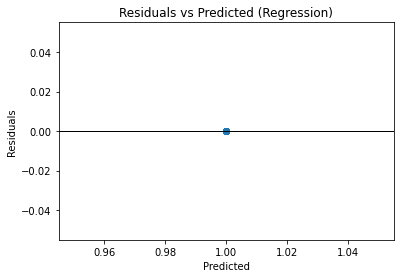

Saved regression predictions to: abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/olympic/predictions/regression_medal_predictions.csv


In [0]:
import os
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Create binary target column: medal_count ---
df['medal_count'] = ((df['gold'] > 0) | (df['silver'] > 0) | (df['bronze'] > 0)).astype(int)
print("Created 'medal_count' column. Sample values:\n", df['medal_count'].value_counts())

# --- Define features ---
numeric_candidates = ['age', 'height', 'weight', 'gold', 'silver', 'bronze', 'total', 'rank', 'rank by total', 'female', 'male']
categorical_candidates = ['gender', 'noc', 'sport', 'teamcountry', 'teamname', 'discipline', 'country', 'event', 'name']

FEATURES = [col for col in numeric_candidates if col in df.columns]
CATEGORICALS = [col for col in categorical_candidates if col in df.columns]

print("Numeric features:", FEATURES)
print("Categorical features:", CATEGORICALS)

# --- Prepare data for regression ---
if 'medal_count' not in df.columns:
    print("Medal_Count column not found, cannot run regression.")
elif len(FEATURES) + len(CATEGORICALS) == 0:
    print("No features found for regression.")
else:
    X = df[FEATURES + CATEGORICALS]
    y = df['medal_count'].values.ravel()  # ensure 1D target

    numeric_transformer = Pipeline([('scaler', StandardScaler())])
    categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

    transformers = []
    if FEATURES:
        transformers.append(('num', numeric_transformer, FEATURES))
    if CATEGORICALS:
        transformers.append(('cat', categorical_transformer, CATEGORICALS))

    preprocessor = ColumnTransformer(transformers=transformers)

    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    # Uncomment below to use XGBoost if available:
    # if XGBOOST_AVAILABLE:
    #     regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    mlflow.set_experiment('/Workspace/Users/shreyparmar.ca@gmail.com/Olympic-ML')
    with mlflow.start_run(run_name='regression_medal_count'):
        reg_pipeline.fit(X_train, y_train)
        y_pred = reg_pipeline.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metric('rmse', float(rmse))
        mlflow.log_metric('mae', float(mae))
        mlflow.log_metric('r2', float(r2))
        mlflow.sklearn.log_model(reg_pipeline, 'regression_medal_pipeline')

    print(f"Regression results -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Regression)')
    plt.show()

    preds_df = X_test.copy()
    preds_df['actual_medal_count'] = y_test
    preds_df['predicted_medal_count'] = y_pred

    # Add extra columns if available
    for col in ['athlete_id', 'athlete', 'country', 'noc']:
        if col in df.columns and col not in preds_df.columns:
            preds_df[col] = df.loc[X_test.index, col].values

    out_path = os.path.join(OUTPUT_PREDICTIONS_PATH, 'regression_medal_predictions.csv')
    preds_spark = spark.createDataFrame(preds_df)
    preds_spark.write.mode('overwrite').option('header', True).csv(out_path)
    print('Saved regression predictions to:', out_path)


In [0]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(reg_pipeline, X.fillna(0), y, cv=5, scoring='r2')
print('Cross-val R2 scores:', scores)
print('Mean R2:', np.mean(scores))

Cross-val R2 scores: [1. 1. 1. 1. 1.]
Mean R2: 1.0


In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create binary target
df['won_medal'] = ((df['gold'] > 0) | (df['silver'] > 0) | (df['bronze'] > 0)).astype(int)

# Features excluding medal count columns to prevent leakage
FEATURES = [c for c in ['rank', 'rank by total', 'female', 'male'] if c in df.columns]
CATEGORICALS = [c for c in ['teamcountry', 'teamname', 'discipline', 'country', 'event', 'name'] if c in df.columns]

X = df[FEATURES + CATEGORICALS]
y = df['won_medal']

# Preprocessing pipelines
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, FEATURES),
    ('cat', categorical_transformer, CATEGORICALS),
])

# Model pipeline
clf = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       116

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



In [0]:
# ---------------------------
# 7. Clustering (KMeans) on country-level aggregated data
# ---------------------------
print('\n--- Clustering: KMeans on aggregated country metrics ---')

if 'country' in df.columns:
    group = df.groupby('country')

    # Aggregate medal count and athlete count
    country_df = group.agg({'medal_count': 'sum'}).rename(columns={'medal_count': 'total_medals'})
    country_df['athlete_count'] = group.size()

    # Optional: average age if available
    if 'age' in df.columns:
        country_df['mean_age'] = group['age'].mean()

    country_df = country_df.fillna(0).reset_index()

    cluster_features = ['total_medals', 'athlete_count'] + (['mean_age'] if 'mean_age' in country_df.columns else [])
    X_cluster = country_df[cluster_features]

    # Standardize features before clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # Perform KMeans clustering
    k = 4  # Number of clusters, you can adjust this
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    country_df['cluster'] = cluster_labels
    print(country_df.head())

    # Save results to storage
    out_path = os.path.join(OUTPUT_PREDICTIONS_PATH, 'country_clusters.csv')
    cluster_spark = spark.createDataFrame(country_df)
    cluster_spark.write.mode('overwrite').option('header', True).csv(out_path)
    print('Saved country clusters to:', out_path)
else:
    print('Skipping clustering: country column not found.')



--- Clustering: KMeans on aggregated country metrics ---
     country  total_medals  athlete_count  cluster
0  Argentina            16             16        2
1  Australia            41             41        1
2    Austria             3              3        0
3    Bahrain             1              1        0
4    Belarus             1              1        0
Saved country clusters to: abfss://tokyo-olympic-data@azuretokyoolympicdata.dfs.core.windows.net/olympic/predictions/country_clusters.csv


In [0]:
# ---------------------------
# 8. Time Series Forecasting (Prophet)
# ---------------------------
print('\n--- Time Series Forecasting: Example per-country using Prophet (if available) ---')

# Check if 'year' column exists in pandas df
if 'year' not in df.columns:
    print("Year column missing in pandas df; attempting to add from medals Spark DataFrame...")

    # medals columns you showed do NOT have 'Discipline' or 'Year' so try to find a suitable alternative
    # Here, check for 'Year' column first — if not present, print message and skip
    if 'Year' in medals.columns:
        # medals has 'TeamCountry' but no 'Discipline', so join only on 'teamcountry'
        medals_year_df = medals.select("TeamCountry", "Year").distinct()
        medals_year_pd = medals_year_df.toPandas()
        medals_year_pd.columns = [c.strip().lower() for c in medals_year_pd.columns]

        # Merge pandas df with medals_year_pd on 'teamcountry'
        if 'teamcountry' in df.columns and 'teamcountry' in medals_year_pd.columns:
            df = df.merge(medals_year_pd, how='left', on='teamcountry')
            print("Merged 'year' into pandas df on 'teamcountry'. Null year count:", df['year'].isnull().sum())
        else:
            print("Cannot merge year: 'teamcountry' missing in either dataframe.")
    else:
        print("Medals Spark DataFrame has no 'Year' column, cannot add year to pandas df.")

# Proceed if all required columns are present
if PROPHET_AVAILABLE and 'year' in df.columns and 'country' in df.columns and 'medal_count' in df.columns:
    # Select first non-null country for example
    country_example = df['country'].dropna().iloc[0]

    ts = df[df['country'] == country_example].groupby('year').agg({'medal_count': 'sum'}).reset_index()
    ts = ts.rename(columns={'year': 'ds', 'medal_count': 'y'})
    ts['ds'] = pd.to_datetime(ts['ds'].astype(str) + '-01-01')

    m = Prophet()
    m.fit(ts)

    future = m.make_future_dataframe(periods=8, freq='YS')  # yearly start frequency
    forecast = m.predict(future)

    fig = m.plot(forecast)
    plt.title(f'Forecasted Medal Count for {country_example}')
    plt.show()

    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    forecast_df['country'] = country_example

    out_path = os.path.join(OUTPUT_PREDICTIONS_PATH, f'forecast_{country_example}.csv')
    spark.createDataFrame(forecast_df).write.mode('overwrite').option('header', True).csv(out_path)
    print('Saved time series forecast for', country_example)
else:
    print('Skipping time-series: Prophet not available or required columns missing.')



--- Time Series Forecasting: Example per-country using Prophet (if available) ---
Year column missing in pandas df; attempting to add from medals Spark DataFrame...
Medals Spark DataFrame has no 'Year' column, cannot add year to pandas df.
Skipping time-series: Prophet not available or required columns missing.


In [0]:
# ---------------------------
# 9. Cross-validation example (Regression)
# ---------------------------
print('\n--- Cross-validation example (Regression) ---')
if 'Medal_Count' in df.columns and len(FEATURES) > 0:
    scores = cross_val_score(reg_pipeline, X.fillna(0), y, cv=5, scoring='r2')
    print('Cross-val R2 scores:', scores)
    print('Mean R2:', np.mean(scores))
else:
    print('Skipping cross-validation example (no Medal_Count/features).')

print('\nNotebook completed.\n')


--- Cross-validation example (Regression) ---
Skipping cross-validation example (no Medal_Count/features).

Notebook completed.

